# Dependencies

In [1]:
import os
import requests

import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.functional import softmax
from PIL import Image, ImageDraw
from transformers import DetrForObjectDetection, DetrFeatureExtractor

C:\Users\runes\.conda\envs\mlops-project\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\runes\.conda\envs\mlops-project\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


# Load model

In [2]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained(
            "facebook/detr-resnet-50", num_labels=20, ignore_mismatched_sizes=True
            )

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([21, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([21]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", 
           "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
           "person","pottedplant", "sheep", "sofa", "train", "tvmonitor"]
n_classes = len(classes) # Note: The 21th class is a placeholder class for "No-Object"

# Load and prepare image

In [4]:
# Find an image url on the net
url = input()

 https://thumbs.dreamstime.com/z/businesspeople-have-team-meeting-office-26487052.jpg


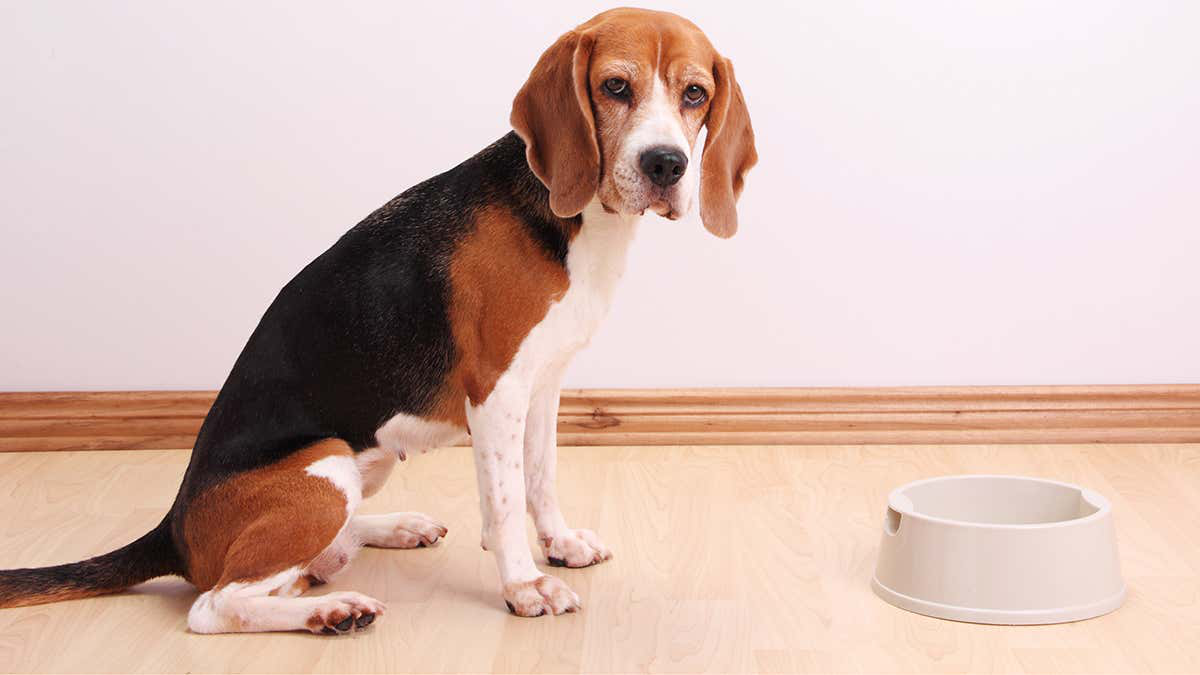

In [12]:
# img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
img = Image.open('../example_image.jpg').convert('RGB')
img_w, img_h = img.size
img

In [13]:
encoding = feature_extractor(images=img, return_tensors='pt')

# Predict

In [14]:
with torch.no_grad():
    output = model(**encoding)

In [15]:
# These are the outputs
output.logits.shape, output.pred_boxes.shape

(torch.Size([1, 100, 21]), torch.Size([1, 100, 4]))

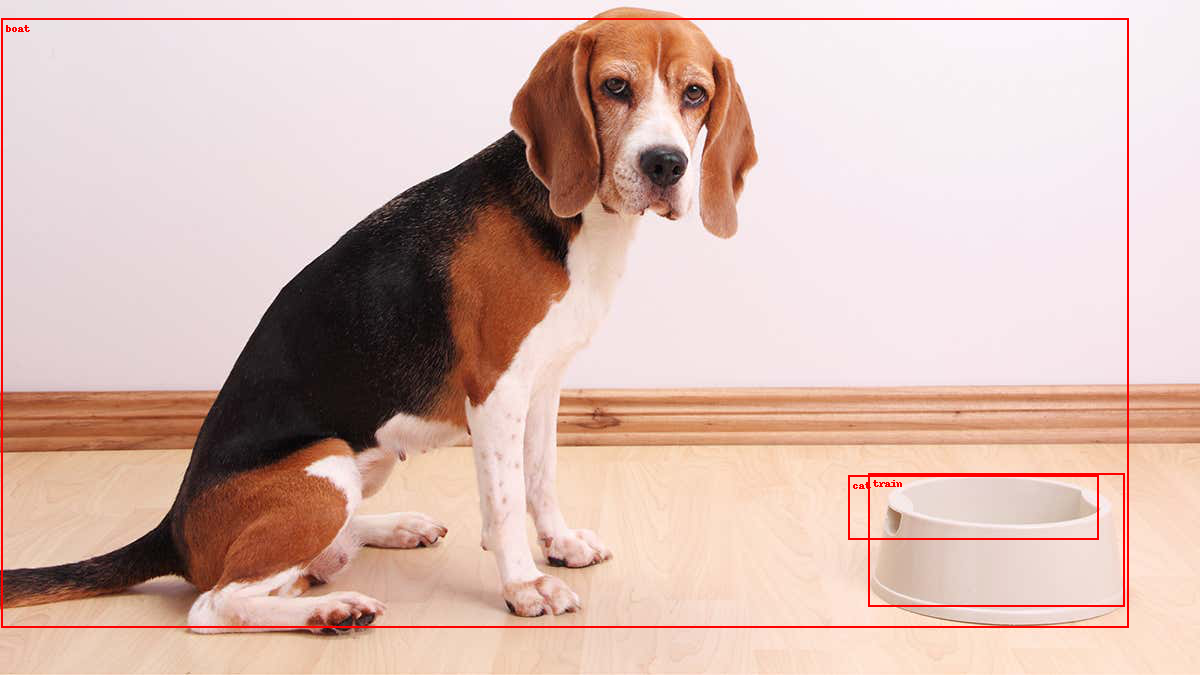

In [25]:
img2 = img.copy()
draw = ImageDraw.Draw(img2, "RGBA")
threshold = .15
# Here we don't actually need the for loop,
# but for batches, we would loop over each image in the batch
for logits, bboxes in zip(output.logits, output.pred_boxes):
    probs = softmax(logits, dim=1)
    best = np.argmax(probs, 1)
    criteria = probs[np.arange(len(best)), best] > threshold
    # preds = best[criteria]
    for pred, box in zip(best[criteria], bboxes[criteria]):
        pred_class = classes[pred] if pred < n_classes else "No Object"
        x,y,w,h = tuple(box)
        x *= img_w
        y *= img_h
        w *= img_w
        h *= img_h
        draw.rectangle((x - w/2, y - h/2, 
                        x + w/2, y + h/2), outline='red', width=2)
        draw.text((x - w/2 + 5, y - h/2 + 5), pred_class, fill='red', size=100)
img2